# Simpler Bridge Autoencoder

This version keeps the demo focused: a light beam simulator, a quick synthetic dataset, and a tiny LSTM autoencoder that learns a 2D latent space.

What you get:
- minimal beam/vehicle functions (no animation boilerplate)
- compact dataset generation and scaling
- a short training loop with clear plots for reconstructions and latent space


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(7)
torch.manual_seed(7)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')


Using cuda


## Beam and Vehicle Model
We keep only the pieces needed for the demo:
- a simply supported beam with a few modes
- a moving point force from a single vehicle
- displacement measured at one sensor (L/4)


In [2]:
BEAM = {
    'L': 20.0,         # beam length (m)
    'EI': 2.0e9,       # bending stiffness
    'rho_A': 2000.0,   # mass per unit length (kg/m)
    'zeta': 0.02,      # damping ratio
    'n_modes': 4,
    'dt': 0.01,
}


def modal_setup(beam=BEAM):
    n = np.arange(1, beam['n_modes'] + 1)
    omega = (n * np.pi / beam['L'])**2 * np.sqrt(beam['EI'] / beam['rho_A'])

    def phi(x):
        # Returns mode shapes evaluated at position x
        x_arr = np.atleast_1d(x)
        return np.sin(np.outer(n, x_arr) * np.pi / beam['L']).squeeze()

    modal_mass = (beam['rho_A'] * beam['L']) / 2
    return n, omega, phi, modal_mass


def simulate_vehicle(mass, speed, beam=BEAM):
    n, omega, phi, modal_mass = modal_setup(beam)
    force = mass * 9.81

    duration = beam['L'] / abs(speed)
    t = np.arange(0, duration + 1.0, beam['dt'])
    y0 = np.zeros(2 * beam['n_modes'])

    def rhs(y, t_):
        pos = speed * t_ if speed > 0 else beam['L'] + speed * t_
        modal_force = force * phi(pos) if 0 <= pos <= beam['L'] else np.zeros_like(n)

        q = y[: beam['n_modes']]
        dq = y[beam['n_modes'] :]
        ddq = (modal_force / modal_mass) - (2 * beam['zeta'] * omega * dq) - (omega**2 * q)
        return np.concatenate([dq, ddq])

    sol = odeint(rhs, y0, t)
    return t, sol


def sensor_signal(sol, beam=BEAM, sensor_ratio=0.25):
    _, _, phi, _ = modal_setup(beam)
    shape_at_sensor = phi(beam['L'] * sensor_ratio)
    q = sol[:, : beam['n_modes']]
    return q @ shape_at_sensor


def resample_signal(t, signal, length=200):
    target_t = np.linspace(t[0], t[-1], length)
    return np.interp(target_t, t, signal)


## One Crossing Demo
A quick look at a single simulated crossing to check the physics helper.


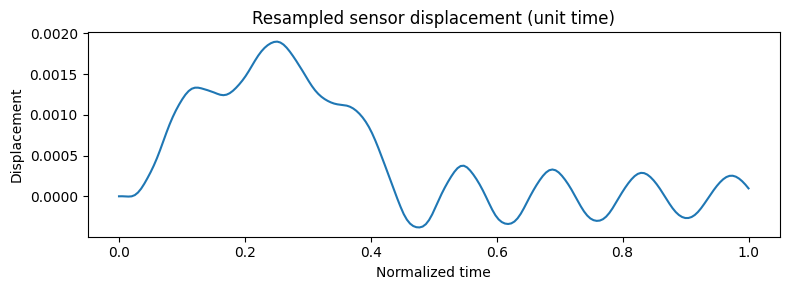

In [26]:
t_demo, sol_demo = simulate_vehicle(mass=2500, speed=25.0)
sensor_demo = sensor_signal(sol_demo, sensor_ratio=0.7)
sensor_resampled = resample_signal(t_demo, sensor_demo)

plt.figure(figsize=(8, 3))
plt.plot(np.linspace(0, 1, len(sensor_resampled)), sensor_resampled)
plt.title('Resampled sensor displacement (unit time)')
plt.xlabel('Normalized time')
plt.ylabel('Displacement')
plt.tight_layout()
plt.show()


## Synthetic Dataset
We randomly sample masses, speeds, and travel directions, simulate the crossing, and keep the resampled sensor signal.


In [4]:
def generate_dataset(n_samples=800):
    signals, labels = [], []
    for _ in range(n_samples):
        mass = np.random.uniform(500, 3000)
        speed = np.random.uniform(5, 25) * np.random.choice([1, -1])

        t, sol = simulate_vehicle(mass, speed)
        sig = resample_signal(t, sensor_signal(sol))

        signals.append(sig)
        labels.append([mass, abs(speed), np.sign(speed)])

    return np.array(signals), np.array(labels)


signals, labels = generate_dataset(800)
print(f'Signals shape: {signals.shape}, Labels shape: {labels.shape}')


Signals shape: (800, 200), Labels shape: (800, 3)


In [5]:
# Scale signals and split
scaler = StandardScaler()
signals_scaled = scaler.fit_transform(signals)

X_train, X_test, y_train, y_test = train_test_split(
    signals_scaled, labels, test_size=0.2, random_state=7
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)

print('Train tensor:', X_train_tensor.shape)
print('Test tensor:', X_test_tensor.shape)


Train tensor: torch.Size([640, 200, 1])
Test tensor: torch.Size([160, 200, 1])


## Tiny LSTM Autoencoder
Two stacked LSTMs would be overkill; a single small one is enough for the 200-sample signals.


In [20]:
class TinyLSTMAutoencoder(nn.Module):
    def __init__(self, seq_len=200, features=1, hidden=64, latent_dim=2):
        super().__init__()
        self.seq_len = seq_len
        self.encoder = nn.LSTM(features, hidden, batch_first=True)
        self.to_latent = nn.Linear(hidden, latent_dim)

        self.to_hidden = nn.Linear(latent_dim, hidden)
        self.decoder = nn.LSTM(hidden, hidden, batch_first=True)
        self.output_layer = nn.Linear(hidden, features)

    def forward(self, x):
        _, (h, _) = self.encoder(x)
        latent = self.to_latent(h.squeeze(0))

        seed = self.to_hidden(latent)
        dec_input = seed.unsqueeze(1).repeat(1, self.seq_len, 1)
        decoded, _ = self.decoder(dec_input)
        recon = self.output_layer(decoded)
        return recon, latent


model = TinyLSTMAutoencoder().to(device)
model


TinyLSTMAutoencoder(
  (encoder): LSTM(1, 64, batch_first=True)
  (to_latent): Linear(in_features=64, out_features=2, bias=True)
  (to_hidden): Linear(in_features=2, out_features=64, bias=True)
  (decoder): LSTM(64, 64, batch_first=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

Epoch 10/10000, loss=0.989249
Epoch 20/10000, loss=0.975104
Epoch 30/10000, loss=0.965799
Epoch 40/10000, loss=0.941397
Epoch 50/10000, loss=0.910962
Epoch 60/10000, loss=0.873591
Epoch 70/10000, loss=0.833125
Epoch 80/10000, loss=0.818628
Epoch 90/10000, loss=0.808244
Epoch 100/10000, loss=0.800544
Epoch 110/10000, loss=0.796077
Epoch 120/10000, loss=0.790805
Epoch 130/10000, loss=0.786661
Epoch 140/10000, loss=0.783586
Epoch 150/10000, loss=0.778193
Epoch 160/10000, loss=0.766209
Epoch 170/10000, loss=0.768689
Epoch 180/10000, loss=0.766981
Epoch 190/10000, loss=0.751974
Epoch 200/10000, loss=0.825912
Epoch 210/10000, loss=0.804617
Epoch 220/10000, loss=0.795598
Epoch 230/10000, loss=0.788499
Epoch 240/10000, loss=0.784749
Epoch 250/10000, loss=0.779514
Epoch 260/10000, loss=0.764134
Epoch 270/10000, loss=0.761842
Epoch 280/10000, loss=0.740704
Epoch 290/10000, loss=0.726470
Epoch 300/10000, loss=0.719538
Epoch 310/10000, loss=0.716196
Epoch 320/10000, loss=0.713781
Epoch 330/10000, 

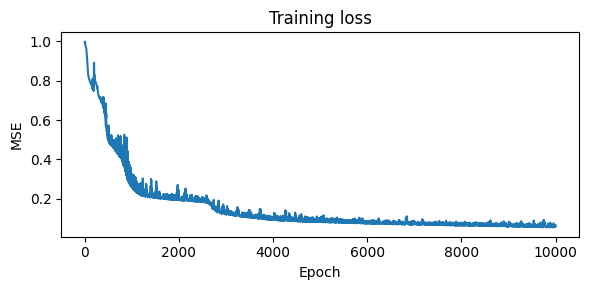

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10000
losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    recon, _ = model(X_train_tensor)
    loss = criterion(recon, X_train_tensor)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1:02d}/{num_epochs}, loss={loss.item():.6f}')

plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training loss')
plt.tight_layout()
plt.show()


## Reconstructions and Latent Space
Check a few reconstructions, then color the 2D latent space by each physical parameter.


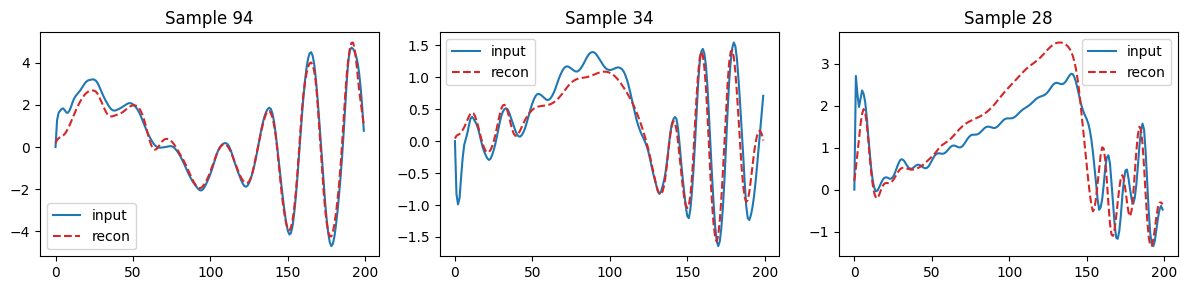

In [22]:
model.eval()
with torch.no_grad():
    recon_test, latent_test = model(X_test_tensor)

recon_np = recon_test.cpu().numpy().squeeze(-1)
latent_np = latent_test.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, idx in enumerate(np.random.choice(len(X_test), 3, replace=False)):
    axes[i].plot(X_test[idx], label='input', color='C0')
    axes[i].plot(recon_np[idx], '--', label='recon', color='C3')
    axes[i].set_title(f'Sample {idx}')
    axes[i].legend()
plt.tight_layout()
plt.show()


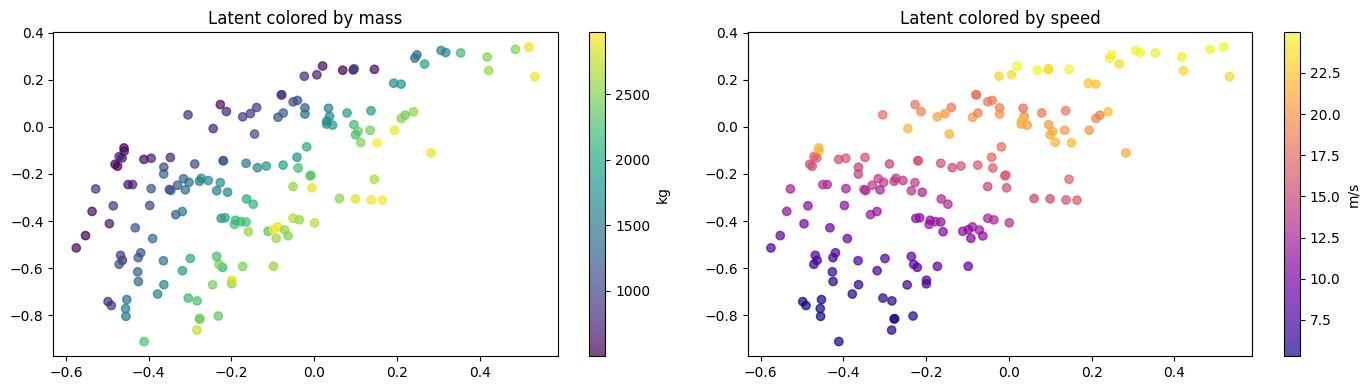

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

mass_sc = axes[0].scatter(latent_np[:, 0], latent_np[:, 1], c=y_test[:, 0], cmap='viridis', alpha=0.7)
axes[0].set_title('Latent colored by mass')
plt.colorbar(mass_sc, ax=axes[0], label='kg')

speed_sc = axes[1].scatter(latent_np[:, 0], latent_np[:, 1], c=y_test[:, 1], cmap='plasma', alpha=0.7)
axes[1].set_title('Latent colored by speed')
plt.colorbar(speed_sc, ax=axes[1], label='m/s')


plt.tight_layout()
plt.show()
